<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1">Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1">Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2">Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3">Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4">Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 40.9 MB/s eta 0:00:00

2023-03-27 16:56:40.101998: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-03-27 16:56:40.102317: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-27 16:56:47.350322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-03-27 16:56:47.351638: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2023-03-27 16:56:47.352941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2023-03-27 16:56:47.354478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu


  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.4.0
    Uninstalling en-core-web-sm-3.4.0:
      Successfully uninstalled en-core-web-sm-3.4.0
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import matplotlib.pyplot as plt
import string
import scipy as sp


from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords 
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.probability import FreqDist
from scipy.sparse import hstack

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv',index_col=0)

In [4]:
df.sample(10)

,text,toxic
14885,"""\nThanks for this update! I am not willing to...",0
146941,dont show me attitude i give u standing ovatio...,1
96767,"""::Actually, guideline supports such lists. Hi...",0
70686,"""\n\nFirst rule is consider everything GOOD FA...",0
140205,"Finally, mention how many Germans lived in Ser...",0
140399,start}}\n\n Rename in line with WP:TITLE,0
132581,"""== Harassment ==\n\nUsers are assumed to have...",0
50053,"(No, I'm not talking about the current instanc...",0
17493,Block of 216.56.4.46 \n\n is Wiscnet: Wisconsi...,0
67332,"legal action is retract, could you provide me ...",0


In [5]:
##df = df[['text', 'toxic']]

In [6]:
##df.head(10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [8]:
df.duplicated().sum()

0

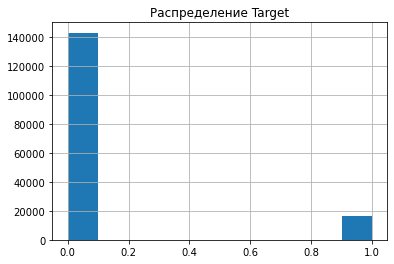

In [9]:
df['toxic'].hist()
plt.title('Распределение Target')
plt.show()

### Вывод

Пропусков нет, дубликатов нет, данные выглядят нормально.

Классы не сбалансированы.

In [10]:
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc if not token.is_stop])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
      
    return " ".join(doc.split())

In [11]:
def lemma_by_spacy_clear(text):
    doc = nlp(text)
    doc=" ".join([token.lemma_ for token in doc])
    doc=re.sub(r'[^a-zA-Z ]',' ',doc)
  
    return " ".join(doc.split())

In [12]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [13]:
#lemmatizer = WordNetLemmatizer()
#
#def lemmatize_text(text):
#    text = text.lower()
#    lemm_text = "".join(lemmatizer.lemmatize(text))
#    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
#    return " ".join(cleared_text.split())
#
#df['lemm_text'] = df['text'].apply(lemmatize_text)
#
#df = df.drop(['text'], axis=1)

In [14]:
#df = df.sample(5000) #уменьшаю выборку иначе выполняется более 30 мин.

In [15]:
%%time
df['lemma_text'] = df['text'].apply(lemma_by_spacy_clear)

Wall time: 21min 32s


In [16]:
df['len_text'] = df['text'].apply(len)

In [17]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

In [18]:
features = df[['lemma_text', 'len_text', 'num_words']]
target = df['toxic']

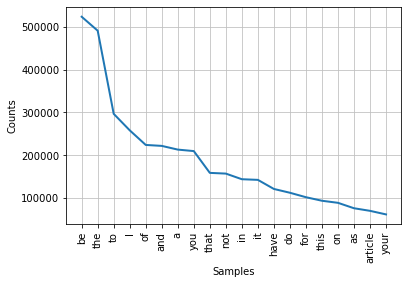

In [19]:
text = df['lemma_text']
text = "".join([ch for ch in text if ch not in string.digits])
text = word_tokenize(text)
text = nltk.Text(text)
fdist = FreqDist(text)
fdist.plot(20,cumulative=False)
plt.show()

Похоже что это отзывы на википедии)

In [20]:
features_train,features_test,target_train,target_test=train_test_split(features,
                                                                       target,
                                                                       test_size=0.3,
                                                                       random_state=12345,
                                                                       stratify=target)

In [21]:
#Функция балансировки
#def upsample(features, target, repeat): 
#    features_zeros = features[target == 0]
#    features_ones = features[target == 1]
#    target_zeros = target[target == 0]  
#    target_ones = target[target == 1]
#    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
#    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
#    features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=42)
#    return features_upsampled, target_upsampled

In [22]:
#features, target = upsample(corpus_lemma, target, repeat=8)

In [23]:
#target.hist()
#plt.title('Распределение Target')
#plt.show()

In [24]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Иван\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
features_train_tfidf = count_tf_idf.fit_transform(features_train['lemma_text'])
features_test_tfidf = count_tf_idf.transform(features_test['lemma_text'])

In [26]:
new_column1 = np.array(features_train[['len_text','num_words']])
new_column2 = np.array(features_test[['len_text','num_words']])

In [27]:
features_train_tfidf_f = sp.sparse.hstack((features_train_tfidf, new_column1))
features_test_tfidf_f = sp.sparse.hstack((features_test_tfidf, new_column2))

In [28]:
#features_train, features_valid, target_train, target_valid = train_test_split(features, 
#                                                                              target, 
#                                                                              test_size=0.5, 
#                                                                              random_state=12345,
#                                                                              stratify=target)
#features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
#                                                                            target_valid, 
#                                                                            test_size=0.5,
#                                                                            random_state=12345)

## Обучение

LogisticRegression

In [29]:
%%time
classificator = LogisticRegression(class_weight='balanced')
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]}]
print('Подбор гиперпараметров:')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=2)
clf.fit(features_train_tfidf_f, target_train)

print("Лучшие гиперпараметры:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Таблица гиперпараметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

train_f1_LR = clf.best_score_

Подбор гиперпараметров:

Лучшие гиперпараметры:

{'C': 10, 'solver': 'liblinear'}

Таблица гиперпараметров:

0.702510 for {'C': 0.1, 'solver': 'newton-cg'}
0.642874 for {'C': 0.1, 'solver': 'lbfgs'}
0.702468 for {'C': 0.1, 'solver': 'liblinear'}
0.746630 for {'C': 1, 'solver': 'newton-cg'}
0.660875 for {'C': 1, 'solver': 'lbfgs'}
0.745499 for {'C': 1, 'solver': 'liblinear'}
0.763645 for {'C': 10, 'solver': 'newton-cg'}
0.651315 for {'C': 10, 'solver': 'lbfgs'}
0.764179 for {'C': 10, 'solver': 'liblinear'}

Wall time: 1min 40s


In [30]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train_tfidf_f, target_train)
target_predict = classificator.predict(features_test_tfidf_f)
test_f1_LR = f1_score(target_test, target_predict)
print('F1 на тесте', test_f1_LR)

F1 на тесте 0.7583412774070541


In [31]:
%%time
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[1515],}]


print('Подбор гиперпараметров:')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=2)
clf.fit(features_train_tfidf_f, target_train)
print("Лучшие гиперпараметры:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Таблица гиперпараметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

train_f1_DTC = clf.best_score_

Подбор гиперпараметров:

Лучшие гиперпараметры:

{'max_depth': 88, 'random_state': 1515}

Таблица гиперпараметров:

0.706897 for {'max_depth': 50, 'random_state': 1515}
0.706248 for {'max_depth': 52, 'random_state': 1515}
0.706713 for {'max_depth': 54, 'random_state': 1515}
0.705190 for {'max_depth': 56, 'random_state': 1515}
0.708884 for {'max_depth': 58, 'random_state': 1515}
0.711552 for {'max_depth': 60, 'random_state': 1515}
0.711593 for {'max_depth': 62, 'random_state': 1515}
0.709999 for {'max_depth': 64, 'random_state': 1515}
0.714659 for {'max_depth': 66, 'random_state': 1515}
0.711712 for {'max_depth': 68, 'random_state': 1515}
0.713634 for {'max_depth': 70, 'random_state': 1515}
0.712011 for {'max_depth': 72, 'random_state': 1515}
0.713639 for {'max_depth': 74, 'random_state': 1515}
0.713064 for {'max_depth': 76, 'random_state': 1515}
0.714310 for {'max_depth': 78, 'random_state': 1515}
0.714606 for {'max_depth': 80, 'random_state': 1515}
0.715338 for {'max_depth': 82, 'rand

In [32]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train_tfidf_f, target_train)
target_predict = classificator.predict(features_test_tfidf_f)
test_f1_DTC = f1_score(target_test, target_predict)

print('F1 на тесте', test_f1_DTC)

F1 на тесте 0.7168


In [33]:
%%time
classificator = CatBoostClassifier(verbose = False)
#hyperparams = {'depth'         : [4,7,10],
#                 'learning_rate' : [0.01,0.03,0.04],
#                  'iterations'    : [10,50,100]
#                 }
hyperparams = {'iterations'    : [200,250,300]}
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=2,n_jobs=-1)
clf.fit(features_train_tfidf_f,target_train)


print("Лучшие гиперпараметры:")
print()
CBC_best_params = clf.best_params_
print(CBC_best_params)
print()
print("Таблица гиперпараметров:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()
test_f1_CBC = clf.best_score_

Лучшие гиперпараметры:

{'iterations': 300}

Таблица гиперпараметров:

0.731569 for {'iterations': 200}
0.732427 for {'iterations': 250}
0.733735 for {'iterations': 300}

Wall time: 8min 4s


In [34]:
classificator.fit(features_train_tfidf_f, target_train)
target_predict = classificator.predict(features_test_tfidf_f)

train_f1_CBC = f1_score(target_test, target_predict)

In [35]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на обучении':[train_f1_LR,
                    train_f1_DTC,
                    train_f1_CBC],
        'F1 на тесте':[test_f1_LR,
                           test_f1_DTC,
                           test_f1_CBC]}


scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на тесте'] > 0.75
scores_data

,F1 на обучении,F1 на тесте,Выполнение задачи
LogisticRegression,0.764179,0.758341,True
DecisionTreeClassifier,0.718624,0.716800,False
CatBoostClassifier,0.751805,0.733735,False


## Выводы

Произведена загрузка и предпросмотр данных.

Использовались библиотеки
numpy 
pandas  
re
nltk
spacy
matplotlib
string
scipy
nltk 
sklearn
scipy

Произведео создание дополнительных признаков.

Обучены модели LogisticRegression, DecisionTreeClassifier, CatBoostClassifier.

В итоге модель LogisticRegression показала лучшие результаты на обучающей и тестовой выборках.
